## Regresjon: Finne en glidende variabel - alder, ut fra besvarelsene


In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.naive_bayes import  GaussianNB
from sklearn.svm import SVR, LinearSVR 
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier, AdaBoostClassifier

# Hente inn datatsettet, filtrere feil og utliggere alder
df_data = pd.read_csv("b5_svar.csv")
df_data = df_data[df_data["gender"].isin([1, 2]) &  df_data.age.isin(range(16,51))]
spm_grupper = {"E": "Extraversion", "A": "Agreeableness", "C": "Conscientiousness", "N": "Emotional Stability", "O": "Intellect/Imagination"}
five = ['N', 'C', 'E', 'A', 'O']
spm_c = [c for c in df_data.columns if c[-1].isdigit() and not c.startswith("Unnamed")] # De 50 spørsmålene
print(list(df_data.columns))
print("data values:",df_data[spm_c].min().min(), df_data[spm_c].max().max())

['Unnamed: 0', 'race', 'age', 'engnat', 'gender', 'hand', 'source', 'country', 'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'O1', 'O2', 'O3', 'O4', 'O5', 'O6', 'O7', 'O8', 'O9', 'O10', 'E', 'N', 'A', 'C', 'O']
data values: 1.0 5.0


In [7]:
x = df_data[spm_c]
y = df_data["age"]
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2)
model = SVR(C= 3, kernel= 'rbf')
model.fit(x_train, y_train)


SVR(C=3)

In [8]:
y_pred = model.predict(x_test)
df_agepred = pd.DataFrame({"Predicted": y_pred, "True": y_test})

<AxesSubplot:xlabel='True_age'>

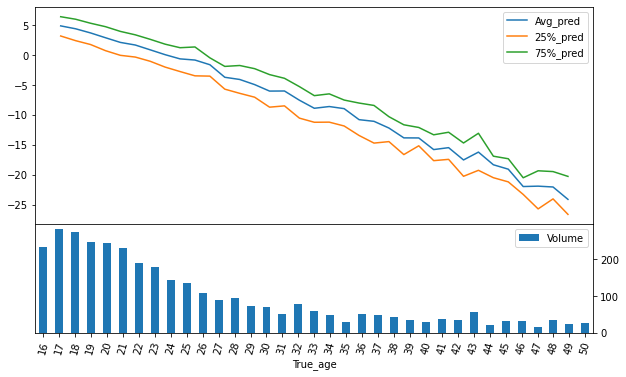

In [39]:
calc = [] #Add a dict for each true age
for age, group in df_agepred.groupby("True"):
    preds = group["Predicted"].to_numpy()
    calc.append({"True_age": age, "Avg_pred": preds.mean()-age,
     "25%_pred": np.percentile(preds, 25)-age,  "75%_pred": np.percentile(preds, 75)-age , "Volume": len(group)})
df_preds = pd.DataFrame(calc).set_index("True_age", drop = True)

fig = plt.figure(figsize=(10,6))
ax1 = plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=2)
ax2 = plt.subplot2grid((3,3), (2,0), colspan=3)
ax2.yaxis.tick_right()
ax1.axes.get_xaxis().set_visible(False)
fig.subplots_adjust(hspace=0)
df_preds.drop('Volume', axis=1).plot(ax=ax1)
df_preds['Volume'].plot(kind='bar',ax=ax2, rot=75, legend=True)



In [4]:
cc5 = ['US', 'GB', 'IN', 'AU', 'CA']
c_conv = {'US':1, 'GB':2, 'IN':3, 'AU':4, 'CA':5, 'other':0}

x = df_data[spm_c]
y = df_data["age"]
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2)

#Scikit-learn pipeline

# from sklearn.linear_model import ElasticNet, from sklearn.linear_model import BayesianRidge
grids = {} # Collect individual pipelines
modeller = [
    {"name": "LM_Ridge", "model": linear_model.Ridge(), 
                     "params": {'model__alpha': [0.01, 0.1, 0.3,0.5, 0.8], 'model__tol': [0.9, 0.5, 0.1, 0.01]}},
    {"name": "ElasticNet", "model": linear_model.ElasticNet(), 
                    "params": {"model__alpha": [0.5,1.0, 1,4], "model__l1_ratio": [0.2, 0.5, 0.8]}},
    {"name": "BayesianRidge", "model": linear_model.BayesianRidge(), 
     "params":{'model__alpha_1': [1e-5, 1e-6, 1e-7], 'model__alpha_2': [1e-5, 1e-6, 1e-7], 'model__lambda_1': [1e-5, 1e-6, 1e-7] }},
    {"name": "KernelRidge", "model": KernelRidge(), 
                    "params": {"model__alpha": [0.1, 0.5,1.0, 2.0]}},   
    {"name": "GradientBoostingRegressor", "model": GradientBoostingRegressor(), 
                    "params": {"model__loss":['ls', 'lad', 'huber' ],"model__max_depth": [2,3,4,5,6]}},  
    {"name": "LinearSVR", "model": LinearSVR(), 
        "params": {"model__epsilon":[0.0, 0.001, 0.1, 2], "model__tol": [0.0001, 0.005], "model__C":[0.5, 1.0, 2.0, 10.0]}},  
    {"name": "SVR",   "model": SVR(),
        "params":{"model__kernel":['linear',  'rbf', 'sigmoid'], "model__C": [ 1, 5, 10, 3]}}
    ]

for m in modeller: #Sjekke pat arameternavnene er riktige
    given = set([p[7:] for p in m["params"]])
    pool = set(m["model"].get_params())
    assert given.issubset(pool), print(m["name"],given, pool)

for m in modeller:
    steps = [('scaler', StandardScaler()), ('model', m["model"]) ]
    pipeline = Pipeline(steps)
    parameters = m["params"]
    # print(parameters)
    # print(m["model"].get_params())
    grid = GridSearchCV(pipeline, param_grid = parameters, cv=5, scoring = 'neg_mean_absolute_error')
    grid.fit(x_train, y_train)
    print(m["name"],": Modellen estmierer i snitt %3.1f år feil i alder." % -grid.score(x_test, y_test), "Parametre:", grid.best_params_)
    with open ("age_model_2.txt", "a") as wf:
        wf.write(m["name"]+": Modellen estmierer i snitt %3.1f år feil i alder." % -grid.score(x_test, y_test)+ "Parametre:"+ str(grid.best_params_))
    grids[m["name"]] = grid



LM_Ridge : Modellen estmierer i snitt 6.3 år feil i alder. Parametre: {'model__alpha': 0.01, 'model__tol': 0.9}
ElasticNet : Modellen estmierer i snitt 6.4 år feil i alder. Parametre: {'model__alpha': 0.5, 'model__l1_ratio': 0.2}
BayesianRidge : Modellen estmierer i snitt 6.3 år feil i alder. Parametre: {'model__alpha_1': 1e-05, 'model__alpha_2': 1e-07, 'model__lambda_1': 1e-07}
KernelRidge : Modellen estmierer i snitt 25.3 år feil i alder. Parametre: {'model__alpha': 0.1}
GradientBoostingRegressor : Modellen estmierer i snitt 5.9 år feil i alder. Parametre: {'model__loss': 'lad', 'model__max_depth': 5}
LinearSVR : Modellen estmierer i snitt 6.0 år feil i alder. Parametre: {'model__C': 0.5, 'model__epsilon': 0.001, 'model__tol': 0.0001}
SVR : Modellen estmierer i snitt 5.8 år feil i alder. Parametre: {'model__C': 3, 'model__kernel': 'rbf'}
